# To do

- FIgure out the correct test and validation strategy: The data are a bunch of time series, so we want to be careful not ending up using future data in training when predicting on test/validation. Exactly what info is available for predictions on the actual data? We should try and mimic that in our data split. 
- Setup experiment tracking: Experiment with preprocessing / feature engineering and model types. Get inspiration from other Kaggle notebooks in terms om preprocessing / features and model specifications to try. 
- Use stacking (if runtime permits)

# EDA

## Background
Source: https://www.kaggle.com/code/tomforbes/optiver-trading-at-the-close-introduction

Each trading day on the Nasdaq Stock Exchange concludes with the Nasdaq Closing Cross auction. This process establishes the official closing prices for securities listed on the exchange. Almost 10% of Nasdaq’s average daily volume occurs in the closing auction. 

We are challenged to develop a model capable of predicting the closing price movements for hundreds of Nasdaq listed stocks using data from the order book and the closing auction of the stock.

### Financial concepts
 **Auction**
 
 In financial markets, an auction is a mechanism for determining the price of a particular asset by allowing multiple buyers and sellers to interact directly in a controlled, regulated environment.

 In a closing auction, orders are collected over a pre-determined timeframe and then matched at a single price determined by the buy & sell demand expressed by auction participants. For Nasdaq Closing auctions, the exchange begins accepting orders at the start of the trading day and begins publishing the state of the auction book at 3:50pm ET for 10 minutes before the market closes at 4pm ET, at which point the orders are matched instantly at a single price.

 The closing price is determined as: The price at which the maximum number of shares can be matched.

 **Continious trading order book**
 
 The term order book refers to an electronic list of buy (also known as bid) and sell (also known as ask) orders for a specific security or financial instrument organized by price level. For an order book in continuous trading, the highest bid price will always be less than the lowest ask price, since otherwise the orders would be matched. 

 **Acution order book**

 The auction order book behaves slightly differently to the order book for continuous trading. In this book, the orders are not immediately matched, but instead collected until the moment the auction ends. The book is referred to as *in cross* if best bid and ask are overlapping. The closing auction price is therefore referred to as the *uncross price*. The matched size is the number of shares matched at a given uncross price. The imbalance is the number of unmathced shares in the bid/ask direction depending on if the umatched shares at a higher/lower price than the closing price. The term far price refers to the hypothetical uncross price of the auction book, if it were to uncross at the reporting time. Nasdaq provides far price information 5 minutes before the closing cross.

 **Combined order book**

 Combining the two books can result in a more accurate reflection of the market's buying and selling interest at different price levels. This aids in better price discovery, allowing the market to reach a more accurate and fair equilibrium price when the auction uncrosses.

 The hypothetical uncross price of combined book is called the near price. Nasdaq provides near price information 5 minutes before the closing cross. Nasdaq also provides an indication of the fair price called the reference price.

# Training data

In [1]:
import pandas as pd
import numpy as np
# from mlxtend.evaluate import GroupTimeSeriesSplit
# from sklearn.model_selection import TimeSeriesSplit

pd.options.display.float_format = '{:,}'.format

In [2]:
df_train = pd.read_csv("../data/train.csv")

In [3]:
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,"5,237,980.0","5,237,980.0","5,237,980.0","5,237,760.0","5,237,980.0","5,237,760.0","5,237,760.0","2,343,638.0","2,380,800.0","5,237,760.0","5,237,980.0","5,237,760.0","5,237,980.0","5,237,760.0","5,237,892.0","5,237,980.0"
mean,99.28855684825066,241.51003822084087,270.0,"5,715,293.098653004",-0.011896188988885028,0.9999955386233814,"45,100,245.28441664",1.001712869102652,0.9996601060681288,0.99972629069526,"51,813.5928547379",1.0002644967753378,"53,575.683292822796",0.999991952552236,-0.047561245607892856,"13,310.052102146246"
std,57.8717557687394,138.5318986566172,158.74509381715032,"20,515,906.297188506",0.8853373908988599,0.0025324970824045757,"139,841,291.27738652",0.7214705227254858,0.012169197249589108,0.002499345050271754,"111,421.40554800438",0.0025100418046468827,"129,355.43570074589",0.0024975087172827474,9.4528596867615,"7,619.270963149553"
min,0.0,0.0,0.0,0.0,-1.0,0.935285,"4,316.61",7.7e-05,0.786988,0.934915,0.0,0.939827,0.0,0.938008,-385.2898,0.0
25%,49.0,122.0,130.0,"84,534.15",-1.0,0.998763,"5,279,575.165",0.996332,0.9971,0.998529,"7,374.72",0.999029,"7,823.7",0.998781,-4.5597553,"6,729.0"
50%,99.0,242.0,270.0,"1,113,604.44",0.0,0.999967,"12,882,638.559999999",0.999883,0.999889,0.999728,"21,969.0",1.000207,"23,017.92",0.999997,-0.06020069,"13,345.0"
75%,149.0,361.0,410.0,"4,190,951.0025",1.0,1.001174,"32,700,130.58",1.003318,1.00259,1.000905,"55,831.68",1.001414,"57,878.41",1.001149,4.4095516,"19,907.0"
max,199.0,480.0,540.0,"2,982,027,811.68",1.0,1.077488,"7,713,682,054.05",437.9531,1.309732,1.077488,"30,287,840.0",1.077836,"54,405,000.0",1.077675,446.07043,"26,454.0"


In [4]:
df_train.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,"3,180,602.69",1,0.999812,"13,380,276.64",NaN,NaN,0.999812,"60,651.5",1.000026,"8,493.03",1.0,-3.029704,0,0_0_0
1,1,0,0,"166,603.91",-1,0.999896,"1,642,214.25",NaN,NaN,0.999896,"3,233.04",1.00066,"20,605.09",1.0,-5.519986,0,0_0_1
2,2,0,0,"302,879.87",-1,0.999561,"1,819,368.03",NaN,NaN,0.999403,"37,956.0",1.000298,"18,995.0",1.0,-8.38995,0,0_0_2
3,3,0,0,"11,917,682.27",-1,1.000171,"18,389,745.62",NaN,NaN,0.999999,"2,324.9",1.000214,"479,032.4",1.0,-4.0102005,0,0_0_3
4,4,0,0,"447,549.96",-1,0.999532,"17,860,614.95",NaN,NaN,0.999394,"16,485.54",1.000016,434.1,1.0,-7.3498487,0,0_0_4


<Axes: >

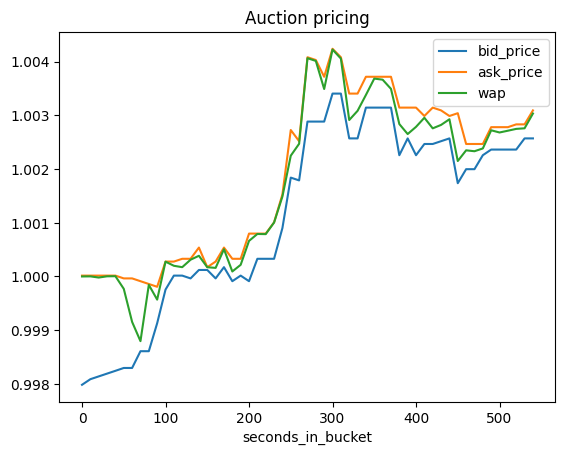

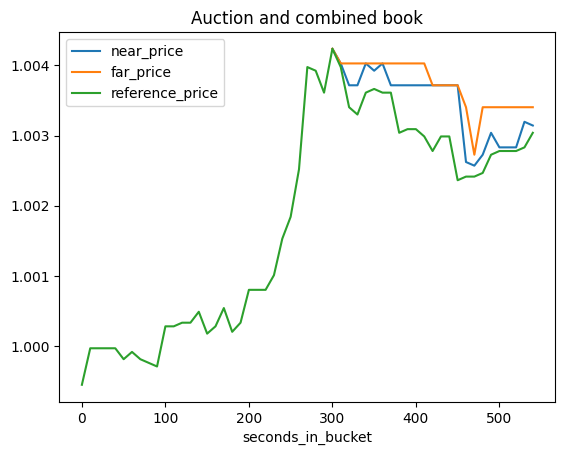

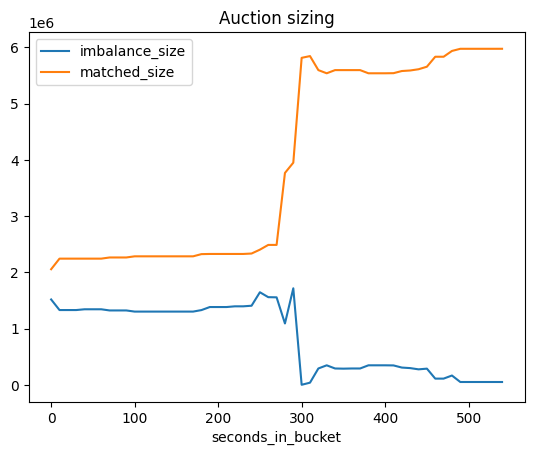

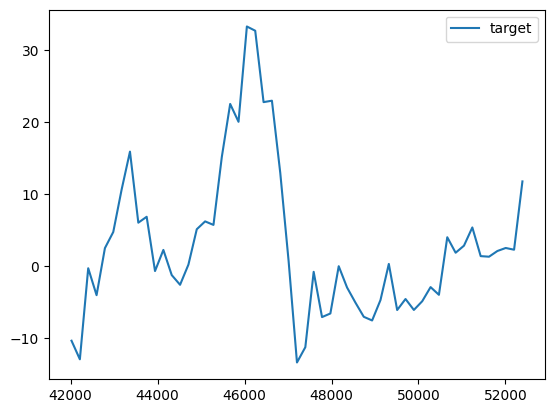

In [5]:
stock_id = 2
date_id = 4
(
    df_train
    .query("stock_id == @stock_id & date_id == @date_id")
    [["seconds_in_bucket", "bid_price", "ask_price", "wap"]]
    .set_index("seconds_in_bucket")
    .plot(title = "Auction pricing")
)
(
    df_train
    .query("stock_id == @stock_id & date_id == @date_id")
    [["seconds_in_bucket", "near_price", "far_price", "reference_price"]]
    .set_index("seconds_in_bucket")
    .plot(title="Auction and combined book")
)
(
    df_train
    .query("stock_id == @stock_id & date_id == @date_id")
    [['seconds_in_bucket','imbalance_size','matched_size']]
    .set_index('seconds_in_bucket')
    .plot(title='Auction sizing')
)
(
    df_train
    .query("stock_id == @stock_id & date_id == @date_id")
    [["target"]]
    .plot()
)

## Preprocessing

**Reduce data size**

Data contains several columns which are stored as float64 and int64, which takes up a large amount of memory for no good reason. We will convert these to 16-bit verions. 

In [6]:
df_train_floats = df_train.select_dtypes(np.float64).drop("target", axis = 1) # keep target in 64-bit
df_train_ints = df_train.select_dtypes(np.int64)

df_train[df_train_floats.columns] = df_train_floats.astype(np.float16)
df_train[df_train_ints.columns] = df_train_ints.astype(np.int16)

/home/martin-svensson/miniconda3/envs/Kaggle_Optiver_Trading-at-the-close/lib/python3.11/site-packages/pandas/core/dtypes/astype.py:138: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


## Feature engineering

This part of the EDA should only be done on training data. 

Ideas
- Experiment with features from other Kaggle notebooks

In [17]:
# sort data for timeseries split - with each stock, time_id specifies the time sequence across dates and seconds_in_bucket
df_train = df_train.sort_values(["stock_id", "time_id"])

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,inf,1,1.0,inf,NaN,NaN,1.0,"60,640.0",1.0,"8,496.0",1.0,-3.029704,0,0_0_0
191,0,0,10,inf,1,1.0,inf,NaN,NaN,1.0,"14,000.0",1.0,"23,520.0",1.0,0.38981438,1,0_10_0
382,0,0,20,inf,1,1.0,inf,NaN,NaN,1.0,"4,664.0",1.0,"12,128.0",1.0,4.220009,2,0_20_0
573,0,0,30,inf,1,1.0,inf,NaN,NaN,1.0,"56,000.0",1.0,"46,208.0",1.0,5.4502487,3,0_30_0
764,0,0,40,inf,1,1.0,inf,NaN,NaN,1.0,"14,656.0",1.0,"26,608.0",1.0,3.169775,4,0_40_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237179,199,480,500,inf,-1,1.0029296875,inf,1.0009765625,1.001953125,1.0029296875,inf,1.0029296875,inf,1.0029296875,-7.209778,26450,480_500_199
5237379,199,480,510,inf,-1,1.0029296875,inf,1.0009765625,1.001953125,1.0029296875,inf,1.0029296875,inf,1.0029296875,-9.750128,26451,480_510_199
5237579,199,480,520,inf,-1,1.001953125,inf,1.0009765625,1.001953125,1.001953125,inf,1.001953125,inf,1.001953125,3.6299229,26452,480_520_199
5237779,199,480,530,inf,-1,1.001953125,inf,1.0009765625,1.001953125,1.001953125,inf,1.001953125,inf,1.001953125,4.760027,26453,480_530_199


In [43]:
df_train["max_time"] = df_train.groupby("stock_id")["time_id"].transform("max")
df_training = df_train.loc[df_train["time_id"] < df_train["max_time"] * 0.8]
df_testing = df_train.loc[~df_train["row_id"].isin(df_training["row_id"])]

# Test data

In [10]:
df_test = pd.read_csv("../data/example_test_files/test.csv")
df_revealed_targets = pd.read_csv("../data/example_test_files/revealed_targets.csv")
df_sample_submission = pd.read_csv("../data/example_test_files/sample_submission.csv")

In [7]:
df_test.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id
count,"33,000.0","33,000.0","33,000.0","33,000.0","33,000.0","33,000.0","33,000.0","14,771.0","15,000.0","33,000.0","33,000.0","33,000.0","33,000.0","33,000.0","33,000.0"
mean,99.5,479.0,270.0,"6,636,938.93803697",-0.14784848484848484,1.000150649909091,"50,988,974.383473024",0.9982301328278383,0.9980850902666667,0.9999153548181817,"63,294.903047878775",1.000406528727273,"66,512.53354727273",1.0001538786969695,"26,372.0"
std,57.73518000869735,0.816508952369213,158.74748394700572,"18,468,274.42475323",0.9181088957389287,0.0018903615698980473,"169,510,516.92255798",0.023914908876286677,0.014531719168498951,0.0019311499732625418,"104,273.62254223666",0.0018402889679238214,"141,507.3012390081",0.001837884732789755,47.63124411796037
min,0.0,478.0,0.0,0.0,-1.0,0.97335,"4,316.61",0.804124,0.892179,0.973023,25.87,0.973132,35.34,0.973025,"26,290.0"
25%,49.75,478.0,130.0,"333,351.29",-1.0,0.999381,"5,956,302.8425",0.9940655,0.99624875,0.999206,"9,993.66",0.999628,"12,122.94",0.999399,"26,331.0"
50%,99.5,479.0,270.0,"1,652,494.61",-1.0,1.00024,"13,227,114.3",0.999833,0.999873,1.000034,"28,766.315000000002",1.000451,"32,314.84",1.000229,"26,372.0"
75%,149.25,480.0,410.0,"5,296,196.9",1.0,1.00108025,"34,777,208.05",1.0030955,1.0020575,1.00086225,"71,123.385",1.001297,"75,120.55",1.001059,"26,413.0"
max,199.0,480.0,540.0,"478,154,802.33",1.0,1.009317,"2,834,016,755.07",1.364387,1.10214,1.008752,"3,033,797.92",1.010889,"13,092,094.4",1.009047,"26,454.0"


In [9]:
df_revealed_targets.head()

,stock_id,date_id,seconds_in_bucket,time_id,revealed_target,revealed_date_id,revealed_time_id
0,0.0,478,0,26290,-2.310276,477.0,"26,235.0"
1,1.0,478,0,26290,-12.850165,477.0,"26,235.0"
2,2.0,478,0,26290,-0.43988228,477.0,"26,235.0"
3,3.0,478,0,26290,7.2598457,477.0,"26,235.0"
4,4.0,478,0,26290,4.7802925,477.0,"26,235.0"


When the first time_id for each date (i.e. when seconds_in_bucket equals zero) the API will serve a dataframe providing the true target values for the entire previous date. All other rows contain null values for the columns of interest.

In [11]:
df_sample_submission.head()

,time_id,row_id,target
0,26290,478_0_0,1
1,26290,478_0_1,1
2,26290,478_0_2,1
3,26290,478_0_3,1
4,26290,478_0_4,1
